In [63]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ta
from ta.trend import EMAIndicator
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve,confusion_matrix
import joblib
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier

In [64]:
class DataLoader:
    def __init__(self,path):
        self.path=path
        
    @staticmethod
    def succesfull():
        print("✅Data Loaded succesfully")
        
    def load_data(self):
        data=pd.read_csv(self.path,sep="\t",names=["date","open","high","low","close","volume"])
        data["date"]=pd.to_datetime(data["date"],format="%Y-%m-%d %H:%M")
        data.set_index("date",inplace=True)
        self.succesfull()
        print("👾Shape of Data : ",data.shape)
        return data

class Features:
    def __init__(self,data):
        self.data=data.copy()
        
    @staticmethod
    def succesfull():
        print("✅Features Created succesfully")
        
    def make_features(self):
        self.data["ema_20"]=EMAIndicator(self.data["close"],window=20).ema_indicator()
        self.data["ema_50"]=EMAIndicator(self.data["close"],window=50).ema_indicator()
        self.data["ema_100"]=EMAIndicator(self.data["close"],window=100).ema_indicator()
        for ema,window in zip([20,50,50,100],[15,30,40,80]):
            mean=self.data[f"ema_{ema}"].rolling(window).mean()
            std=self.data[f"ema_{ema}"].rolling(window).std()
            self.data[f"zscore_{ema}_{window}"]=(self.data[f"ema_{ema}"]-mean)/std
        for i in (10,30,50):
            self.data[f"price_score_{i}"]=(self.data["close"]-self.data["close"].rolling(i).mean())/self.data["close"].rolling(i).std()
            self.data[f"pct_change_{i}"]=self.data["close"].pct_change(i)        

        self.data.drop(["ema_20","ema_50","ema_100"],axis=1,inplace=True)
        self.data.dropna(inplace=True)
        print("🏹 Shape Now is : ",self.data.shape)
        return self.data

class Target:
    def __init__(self, data,name):
        self.zone = data.drop(name,axis=1).copy()
        self.data=data.copy()
        
    def make_targets(self):
        scaler=MinMaxScaler(feature_range=(0,1))
        self.zone=scaler.fit_transform(self.zone)

        pca=PCA(n_components=7)
        pca_data=pca.fit_transform(self.zone)
        wcss=[]                              #Finding optimal number of cluster for kmean using Kne method
        for i in range(2,11):
            kmean=KMeans(n_clusters=i,init="k-means++")
            kmean.fit(pca_data)
            wcss.append(kmean.inertia_)
        plt.plot(range(2,11),wcss,label="Knee_Method")
        plt.xticks(range(2,11))
        plt.show()
        
        kmean=KMeans(n_clusters=6,init="k-means++")     
        kmean.fit(pca_data)

        print("-"*50)
        print("Target_Has_Been_Created")
        self.data["zone"]=kmean.labels_
        print(self.data["zone"].value_counts())
        return self.data


class Visualization:
    def __init__(self):
        print("-"*50)
        print("💗 Graph below")
    def plot_graph(self,node):
        data=node.reset_index()
        plt.figure(figsize=(20,6))
        sns.scatterplot(data=data.iloc[20000:25000],x="date",y="close",hue="zone",palette="Set2")
        plt.show()

class Model:
    def __init__(self):
        print("-"*50)
        print("✅ Model Training has been initiated")

    
    def eval_model(self,model,features,X_train,X_test,y_train,y_test):
        # For cross validation
        pred=cross_val_predict(model,X_train,y_train,cv=5)
        # To get score using predict proba
        acc=accuracy_score(y_train,pred)  # return accuracy
        print("-"*50)
        print("✅ Accuracy of model is : ",acc)
        con_mtrx=confusion_matrix(y_train,pred)
        if hasattr(model,"feature_importances_"):  # Check if model have this function or not [Knn not have it]
            Imp=pd.DataFrame({"Name":features,"Importance":model.feature_importances_}).sort_values("Importance",ascending=False)
    
        fig,ax=plt.subplots(1,2,figsize=(14,8))
        sns.heatmap(con_mtrx,annot=True,linewidth=0.2,cmap="Blues",ax=ax[0],fmt="d")
        ax[0].set_title("Confusion_Matrix")
        if hasattr(model,"feature_importances_"):
    
            sns.barplot(data=Imp.head(10),y="Name",x="Importance",palette="viridis")
            ax[1].set_title("Top_10_features")
        
        plt.tight_layout()
        plt.show()
    
        cr=classification_report(y_train,pred)
        print(cr)
    
    def start_training(self,data,name):
        features=data.drop(name,axis=1).columns
        X=data.drop(name,axis=1).values
        print(X.shape)
        print("_"*50)
        print(features)
        print("_"*50)
        y=data["zone"].values
        split=int(X.shape[0]*0.8)
        X_train=X[:split]
        y_train=y[:split]
        X_test=X[split:]
        y_test=y[split:]

        scale_123=MinMaxScaler(feature_range=(0,1))
        X_train=scale_123.fit_transform(X_train)
        X_test=scale_123.transform(X_test)

        print("✅Scaler Has Been Dump")
        joblib.dump(scale_123,"zone_scaler_mm.pkl")
        
        model=XGBClassifier()
        model.fit(X_train,y_train)
        self.eval_model(model,features,X_train,X_test,y_train,y_test)
        
        joblib.dump(model,"zone_detector.pkl")
        print("🤹🏻MODEL SAVED🤹🏻")

In [65]:
def main():
    # Loading data from path
    loader = DataLoader("GBPUSD240.csv")
    df = loader.load_data().copy()

    original=list(df.columns)
    #Feature Engineering
    features=Features(df)
    df=features.make_features().copy()

    #target maker
    target_making=Target(df,original)
    df=target_making.make_targets()

    original.append("zone")
    #Visualization
    visualizing=Visualization()
    visualizing.plot_graph(df)
    
    #Model Training
    model_train=Model()
    model_train.start_training(df,original)

✅Data Loaded succesfully
👾Shape of Data :  (25848, 5)
🏹 Shape Now is :  (25670, 15)


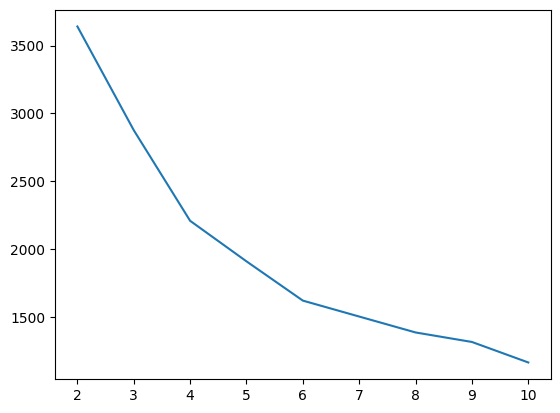

--------------------------------------------------
Target_Has_Been_Created
zone
0    5809
4    5802
5    3844
1    3772
2    3234
3    3209
Name: count, dtype: int64
--------------------------------------------------
💗 Graph below


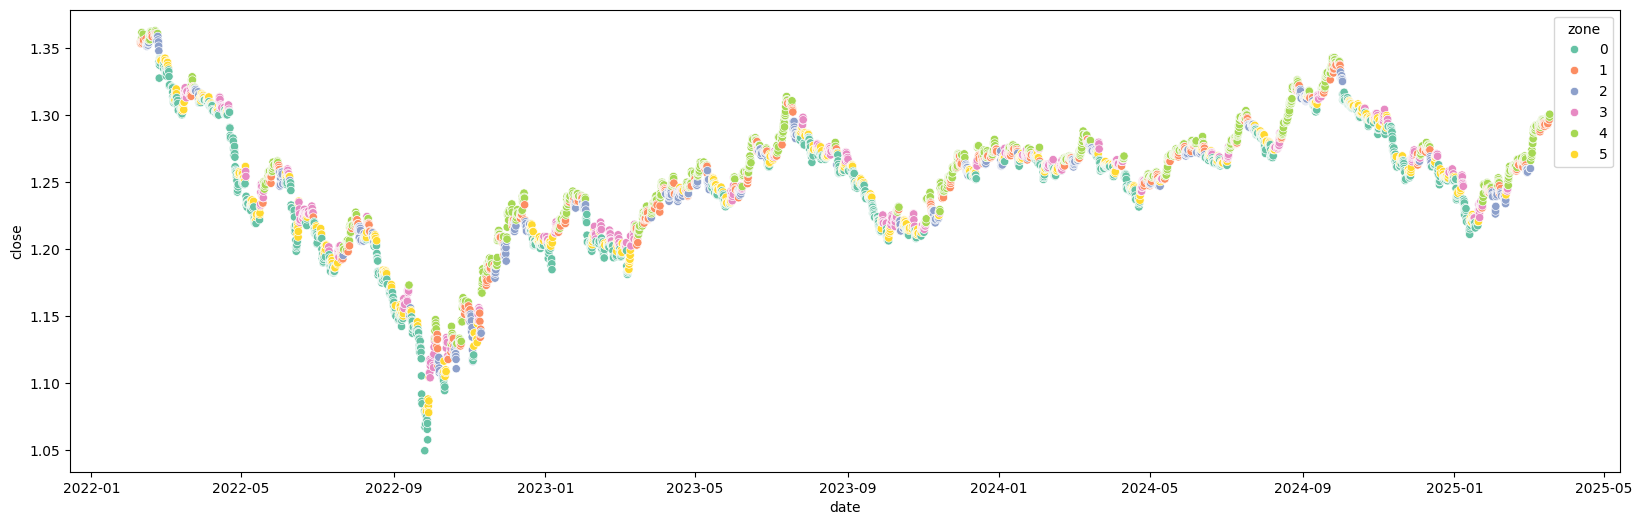

--------------------------------------------------
✅ Model Training has been initiated
(25670, 10)
__________________________________________________
Index(['zscore_20_15', 'zscore_50_30', 'zscore_50_40', 'zscore_100_80',
       'price_score_10', 'pct_change_10', 'price_score_30', 'pct_change_30',
       'price_score_50', 'pct_change_50'],
      dtype='object')
__________________________________________________
✅Scaler Has Been Dump
--------------------------------------------------
✅ Accuracy of model is :  0.9805707051032333


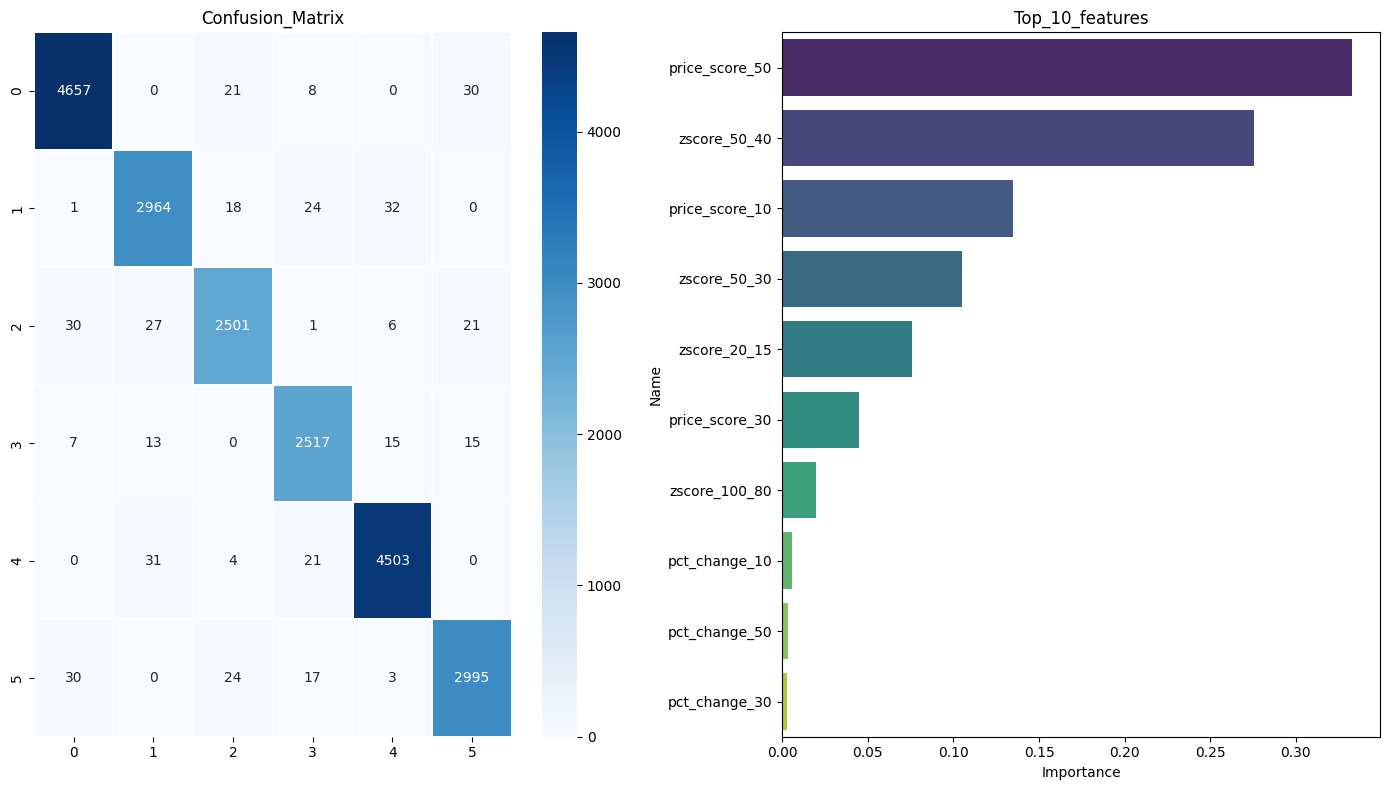

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4716
           1       0.98      0.98      0.98      3039
           2       0.97      0.97      0.97      2586
           3       0.97      0.98      0.98      2567
           4       0.99      0.99      0.99      4559
           5       0.98      0.98      0.98      3069

    accuracy                           0.98     20536
   macro avg       0.98      0.98      0.98     20536
weighted avg       0.98      0.98      0.98     20536

🤹🏻MODEL SAVED🤹🏻


In [66]:
if __name__ == "__main__":
    main()

# 4-Uptrend
# 0-Downtrend